# Political parties

Another very interesting transformer model is the GermanPolitical-Gelectra-base model that was published in collaboration between the University of Hamburg and Ludwig Maximilians University Munich on Huggingface. The model can analyse the political sentiment of statements and evaluate to what extent the different popular German parties would agree with the statement {cite:p}`political_parties`. The model should be used to assign a political party and thus a political orientation to each comment.

The model is based on an pretrained ELECTRA model for German language tasks {cite:p}`political_parties`. Since the pre-processing for this transformer is the same as for the sentiment analysis, it will not be explained further.

In [2]:
from IPython.core.display_functions import display
import pandas as pd
from tqdm import tqdm
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch
from cleantext import clean

In [4]:
comments_df = pd.read_csv("data/youtube_comments_500.csv")
comments_df["Comments"] = comments_df["Comments"].astype(str)

def clean_text(text:str):
    text = clean(text, no_emoji=True, lang="de")
    new_text = []
    for token in text.split(" "):
        if not token.startswith('@') and not token.startswith('http'):
            new_text.append(token)
    return " ".join(new_text)

comments_df["Comments"] = comments_df["Comments"].apply(lambda text: clean_text(text))
comments_df =comments_df[comments_df.Comments != ""]
display(comments_df)

,Unnamed: 0,Comments
0,0,wollt ihr jetzt jeden tag einen großen bericht...
1,1,"wenn scholz alles besser weiss, wieso braucht ..."
2,2,die grünen hatten früher das peace zeichen als...
3,3,der westen ist ein kriegstreiber bis es zu ein...
4,4,frieden schaffen ohne waffen.
...,...,...
406237,406237,"kann jeder deutscher werden ,kein problem sola..."
406238,406238,dann nimm die leute bei dir auf und verpflege ...
406239,406239,als staatenloser hatt mans aber auch nicht lei...
406240,406240,wann kommt der blackout? kinder könnt ihr ja e...


The analysis with this model works somewhat differently than with the sentiment analysis. The model works in such a way that the party must be specified at the beginning of the input and then the statement follows. The model then returns the party's agreement with the statement in the form of two values. One value represents how much the party agrees and the other represents how much the party disagrees with the statement. Currently the model supports the 6 major parties in Germany: CDU/CSU, SPD, FDP, Grüne, Die Linke and AFD. Since we have about 400,000 comments, this means that the model must perform 2.4 million inferences to find the party that most agrees with the statement for each comment.

For the nalaysis, the input for each party is created in the inner for loop and then passed on to the model. The is is checked whether the approval value is higher than the previous maximum value. If this is the case, the current party with the highest approval rating is updated. At the end, for each comment the party with the highest approval and the corresponding confidence value for the approval are added. Then the dataframe is saved. Due to the large number of inferences, this analysis takes a particularly long time and required about 60 hours on the hardware used.

In [ ]:
model_name = "UHH-CI/GermanPolitical-Gelectra-base"
sentiment_tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model_config = AutoConfig.from_pretrained(model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_name, from_tf=True)

label_list = []
score_list = []

political_parties = ["cdu/csu","spd","fdp","grüne","die linke","afd"]

for text in tqdm(comments_df.Comments.to_list()):
    top_party_name = ""
    top_party_score = 0
    for party in political_parties:
        input_text = party+": "+text
        tokenized_input = sentiment_tokenizer(input_text, padding=True, truncation=True, return_tensors='pt', max_length=512)
        output = sentiment_model(**tokenized_input)
        prediction = torch.nn.functional.softmax(output.logits, dim=-1)
        prediction = prediction.detach().numpy()[0]
        if top_party_score < prediction[0]: # label[0] indicates the value for the consent
            top_party_name = party
            top_party_score = prediction[0]

    label_list.append(top_party_name)
    score_list.append(top_party_score)

comments_df["political_party"] = label_list
comments_df["political_party_score"] = score_list
comments_df.to_csv("data/political_parties.csv")

In [4]:
comments_df = pd.read_csv("data/political_parties.csv")
display(comments_df[["Comments", "political_party", "political_party_score"]])

,Comments,political_party,political_party_score
0,wollt ihr jetzt jeden tag einen großen bericht...,die linke,0.498146
1,"wenn scholz alles besser weiss, wieso braucht ...",spd,0.922301
2,die grünen hatten früher das peace zeichen als...,afd,0.629976
3,der westen ist ein kriegstreiber bis es zu ein...,cdu/csu,0.999133
4,frieden schaffen ohne waffen.,die linke,0.999104
...,...,...,...
401277,"kann jeder deutscher werden ,kein problem sola...",grüne,0.882378
401278,dann nimm die leute bei dir auf und verpflege ...,spd,0.999311
401279,als staatenloser hatt mans aber auch nicht lei...,die linke,0.997392
401280,wann kommt der blackout? kinder könnt ihr ja e...,afd,0.901219


The results of this model are very interesting. Most comments are attributed to the "CDU", which is hardly surprising since this is one of the two major parties in Germany. This is followed by the "AFD" with 24%, which is very interesting, as this party is actually much less widespread and usually ranks lower in the elections. In the third place is "Die Linke", which is also interesting because this party is a very small party and this party, like the "AFD", is one of the more extreme parties. If we look at the other parties it is hardly surprising that "Die Grünen" and the "FDP" are in the lower positions. It is more surprising, however, that the "SPD" is in the second last place with only 8%. The "SPD" is the other major party in Germany besides the "CDU" and part of the current government, which is why one would expect much more approval here. In general, it can be said that with the CDU and the AFD in the first two places, conservative views clearly dominate, especially since they together account for 59%. The fact that "Die Linke" follows in third place also suggests that extremist opinions and views are also strongly represented, while the moderate centre is underrepresented.

(0.0, 0.5)

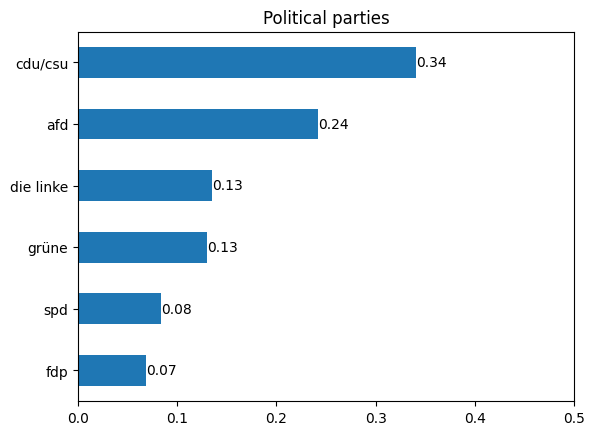

In [10]:
ax = comments_df["political_party"].value_counts(normalize=True).sort_values().plot(kind="barh", title="Political parties")
ax.bar_label(ax.containers[0], fmt="%.2f")
ax.set_xlim(0,0.5)